In [2]:
%matplotlib widget

import sys
import os.path as op
from glob import glob
import fnmatch

import numpy as np
import scipy
from scipy.io import loadmat
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import mne
from mne.io import read_epochs_eeglab
from mne.decoding import SSD
from mne.time_frequency import psd_array_multitaper
from mne.viz import plot_topomap

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import svm

# set path to SpectralEvents
import spectralevents as se

import pdb

In [3]:
def read_data(subj_id, series_num, data_dir, pick_channels=None):
    # read in both pre- and post-TMS sessions belonging to a single subject
    series_num = str(series_num)
    subj_id = subj_id.zfill(4)
    fname_t1 = op.join(data_dir, 'series_' + series_num, 'T1/preprocessed',
                       subj_id + '_Pre_Session1_Series' + series_num + '_Preprocessed.set')
    fname_t2 = op.join(data_dir, 'series_' + series_num, 'T2/preprocessed',
                       subj_id + '_Post_Session1_Series' + series_num + '_Preprocessed.set')

    # read in data
    epochs_pre_post = list()
    for fname in [fname_t1, fname_t2]:
        epochs = read_epochs_eeglab(fname)
        if pick_channels is not None:
            if pick_channels == 'frontal':
                pick_channels = fnmatch.filter(epochs.ch_names, 'F*') + fnmatch.filter(epochs.ch_names, 'C*')
            epochs = epochs.pick_channels(pick_channels)
        epochs_data = epochs.get_data().squeeze()
        #epochs_data -= np.mean(epochs_data, axis=(1, 2), keepdims=True)
        #epochs_data /= np.std(epochs_data, axis=(1, 2), keepdims=True)
        epochs_pre_post.append(epochs_data)
    epochs_info = epochs.info  # save for fit_ssd()
    epoch_times = epochs.times  # save save for spec_event_coherence_shift()
    
    return epochs_pre_post, epochs_info, epoch_times


def plot_features_scatter(x, y, responder_labels, ax_labels):
    '''Plot features across subjects in a 2D scatter plot.'''
    g = sns.JointGrid()

    for class_idx, class_ in enumerate(set(responder_labels)):
        if class_ == 1:
            label = 'responders'
        else:
            label = 'non-responders'
        cluster_mask = responder_labels == class_
        x_data = np.array(x)[cluster_mask]
        y_data = np.array(y)[cluster_mask]

        # plot data points for a given class label (i.e., responder or non-responder)
        sns.scatterplot(x=x_data, y=y_data, alpha=.5, edgecolor=None,
                        color=f'C{class_idx + 1}', ax=g.ax_joint)

        # plot marginal distributions for a given class label
        sns.kdeplot(x=x_data, bw_adjust=0.85, fill=True, linewidth=0, alpha=.5,
                    color=f'C{class_idx + 1}', ax=g.ax_marg_x, label=label)
        g.ax_marg_x.axvline(np.median(x_data), color=f'C{class_idx + 1}')
        sns.kdeplot(y=y_data, bw_adjust=0.85, fill=True, linewidth=0, alpha=.5,
                    color=f'C{class_idx + 1}', ax=g.ax_marg_y)
        g.ax_marg_y.axhline(np.median(y_data), color=f'C{class_idx + 1}')

    g.ax_joint.set_xlabel(ax_labels[0])
    g.ax_joint.set_ylabel(ax_labels[1])
    g.ax_marg_x.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, 1.02))
    g.fig.tight_layout()

In [127]:
def cross_spectral_matrix(chan_coeffs):
    '''Compose the cross-spectral matrix at a specific frequency.'''
    return np.outer(chan_coeffs, chan_coeffs.conj())

def phase_entropy_shift(chan_phases_t0, chan_phases_t1):
    entropies = list()
    for t_samp_phases in (chan_phases_t0, chan_phases_t1):
    
        #magnitudes = np.abs(t_samp_phases)
        angles = np.angle(t_samp_phases)
        
        n_bins = 24
        pmf, bins = np.histogram(angles, bins=n_bins, density=True)
        entropy = scipy.stats.entropy(pmf, np.ones((n_bins,)) / n_bins) # KL-divergence from uniform distribution
        entropies.append(entropy)
    return entropies[1] - entropies[0]

def coherence_shift(chan_coeffs_t0, chan_coeffs_t1):
    '''Coherence shift across channels determined at two timepoints.'''
    
    PC1_phase_offsets = list()
    #PC1_global_coher = list()  # not interesting
    for chan_coeffs in (chan_coeffs_t0, chan_coeffs_t1):
        Pxy = cross_spectral_matrix(chan_coeffs)
        U, s, Vh = np.linalg.svd(Pxy)
        PC1_phase_offsets.append(Vh[0])
        #PC1_global_coher.append(s[0] / np.sum(s))  # not interesting

    # angle between the two vectors of phase offsets
    #dyn_phase_offsets_shift = np.arccos(np.abs(np.sum(PC1_phase_offsets[0] * PC1_phase_offsets[1])))
    # total shift in global coherence ratio
    #dyn_global_coher_shift = PC1_global_coher[1] - PC1_global_coher[0]
    coher_entropy_shift = phase_entropy_shift(PC1_phase_offsets[0], PC1_phase_offsets[1])

    return coher_entropy_shift


def spec_spat_events(epochs_pre_post, times):
    event_band = [9, 14]  # alpha band (Hz)
    #event_band = [15, 29]  # beta band (Hz)
    thresh = 0.99  # factor-of-the-median threshold

    dt = times[1] - times[0]
    samp_freq = 1 / dt
    freqs = np.arange(3, 40)
    n_freqs = len(freqs)

    iei_min = 0.8  # minimum distance between global spectral events; 800 ms
    #dyn_interval = 0.2  # time interval (s) at which the complex TFR will be sampled following a global event
    
    sess_event_rate = list()
    sess_event_avg_freq = list()
    sess_event_phase_offsets_shift = list()
    sess_event_global_coher_init = list()
    sess_event_global_coher_shift = list()
    for epochs_data in epochs_pre_post:
        n_epochs = epochs_data.shape[0]
        n_chans = epochs_data.shape[1]
        n_times = epochs_data.shape[2]
        
        # z-score data across channels and time
        #epochs_data -= epochs_data.mean(axis=(1, 2), keepdims=True)
        #epochs_data /= epochs_data.std(axis=(1, 2), keepdims=True)
        
        # z-score data across time (caution: removes some spatial patterns!)
        #epochs_data -= epochs_data.mean(axis=(2,), keepdims=True)
        #epochs_data /= epochs_data.std(axis=(2,), keepdims=True)

        #### joblib ####
        #tfrs_chan_avg = np.zeros((n_epochs, n_freqs, n_times))
        #tfrs_chans_complex = np.zeros((n_epochs, n_chans, n_freqs, n_times), dtype=complex)
        n_jobs = 24
        output = Parallel(n_jobs=n_jobs)(delayed(se.tfr)(epoch_data, freqs, samp_freq)
                                      for epoch_data in epochs_data)
        epochs_tfrs, epochs_tfrs_complex = zip(*output)
        tfrs_chan_avg = np.mean(np.stack(epochs_tfrs), axis=1)
        tfrs_chans_complex = np.stack(epochs_tfrs_complex)
        del output, epochs_tfrs, epochs_tfrs_complex
        '''
        for epoch_idx, epoch_data in enumerate(epochs_data):
            tfrs, tfrs_complex = se.tfr(epoch_data, freqs, samp_freq)
            # average TFR for this epoch across all channels
            tfrs_chan_avg[epoch_idx, :, :] = np.mean(tfrs, axis=(0,))
            # store complex TFRs for each channel for later
            tfrs_chans_complex[epoch_idx, :, :, :] = tfrs_complex
        '''
        ################
        
        # spectral events need to be found using a common thresh procedure across epochs
        spec_events_global = se.find_events(tfr=tfrs_chan_avg, times=times, freqs=freqs,
                                            event_band=event_band, threshold_FOM=thresh)
        # sanity check: plot "global" events for the 1st epoch
        #fig = se.plot_events(tfr=tfrs_chan_avg[0, :, :],
        #                     times=times,
        #                     freqs=freqs,
        #                     event_band=event_band,
        #                     spec_events=spec_events_global[0])
        n_events = len(sum(spec_events_global, []))
        event_rate = n_events / n_epochs
        print(f'Found {n_events} global spectral events in this session!!!')
        
        event_freqs = list()
        event_coher_shifts = list()
        for epoch_events, epoch_tfrs_complex in zip(spec_events_global, tfrs_chans_complex):

            event_times = np.array([event['Peak Time'] for event in epoch_events])

            event_times_no_overlap = list()
            for event_idx, event_time in enumerate(event_times):
                # crop off events that are too close to the end of the epoch
                if times[-1] - event_time < iei_min:
                    continue

                # don't include events that are shortly followed by another subsequent event
                if event_idx + 1 < len(event_times):
                    next_event_time = event_times[event_idx + 1]
                    if next_event_time - event_time < iei_min:
                        continue
                event_times_no_overlap.append(event_time)

            if len(event_times_no_overlap) > 0:
                # get event peak frequencies to calculate average; concat to master list
                event_freqs += [event['Peak Frequency'] for event in epoch_events
                                if event['Peak Time'] in event_times_no_overlap]

                # sample the complex TFR at the current event across channels
                for event_idx, event_time in enumerate(event_times_no_overlap):
                    event_freq = event_freqs[event_idx]
                    # time interval (s) at which the complex TFR will be sampled following a global event
                    dyn_interval = 2 / event_freq  # 2 periods of the peak event frequency

                    freq_idx = np.nonzero(freqs == event_freq)[0][0]
                    time_idx = np.nonzero(times == event_time)[0][0]
                    later_time_idx = time_idx + int(dyn_interval // dt)
                    
                    chan_coeffs_t0 = epoch_tfrs_complex[:, freq_idx, time_idx]
                    chan_coeffs_t1 = epoch_tfrs_complex[:, freq_idx, later_time_idx]
                    
                    output = coherence_shift(chan_coeffs_t0, chan_coeffs_t1)
                    event_coher_shift = dict(phase_offsets_init=output[0],  # XXX currently ignoring this feature
                                             phase_offsets_shift=output[1],
                                             global_coher_init=output[2],
                                             global_coher_shift=output[3],
                                             phases=output[4])
                    event_coher_shifts.append(event_coher_shift)

        if len(event_coher_shifts) > 0:
            print(f'Kept {len(event_coher_shifts)} events for analysis in this session!!!')
        else:
            raise ValueError("No events were found in this session. Consider decreasing "
                             "threshold_FOM when searching for spectral events!!!")
        # clean up memory
        del tfrs_chan_avg, tfrs_chans_complex
        
        # compile session stats
        sess_event_rate.append(event_rate)
        sess_event_avg_freq.append(np.mean(event_freqs))
        
        all_event_phase_offsets_shifts = [event['phase_offsets_shift'] for event in event_coher_shifts]
        sess_event_phase_offsets_shift.append(np.mean(all_event_phase_offsets_shifts))
        
        all_event_global_coher_init = [event['global_coher_init'] for event in event_coher_shifts]
        sess_event_global_coher_init.append(np.mean(all_event_global_coher_init))
        
        all_event_global_coher_shift = [event['global_coher_shift'] for event in event_coher_shifts]
        sess_event_global_coher_shift.append(np.mean(all_event_global_coher_shift))
        
    sess_event_rate_diff = sess_event_rate[1] - sess_event_rate[0]
    sess_event_avg_freq_diff = sess_event_avg_freq[1] - sess_event_avg_freq[0]
    sess_event_phase_offsets_shift_diff = sess_event_phase_offsets_shift[1] - sess_event_phase_offsets_shift[0]
    #sess_event_global_coher_init_diff = sess_event_global_coher_init[1] - sess_event_global_coher_init[0]
    #sess_event_global_coher_shift_diff = sess_event_global_coher_shift[1] - sess_event_global_coher_shift[0]

    return (sess_event_rate[0], sess_event_rate_diff,
            sess_event_avg_freq[0], sess_event_avg_freq_diff,
            sess_event_phase_offsets_shift[0], sess_event_phase_offsets_shift_diff,
            event_coher_shifts)


def get_features(subj_id, series_num, data_dir):
    '''Main pipeline for computing all features for a given subject.'''
    pick_channels = 'frontal'
    epochs_pre_post, _, times = read_data(subj_id, series_num, data_dir, pick_channels=pick_channels)
    features = spec_spat_events(epochs_pre_post, times)
    return features

In [5]:
# set data directory
data_dir = '/gpfs/data/brainstorm-ws/data/'
data_type = 'TRAINING'

In [6]:
# read metadata from master list
fname_master = op.join(data_dir, data_type, data_type + '_Master List_All Series.csv')
master_keys = np.loadtxt(fname_master,  delimiter=',', max_rows=1, dtype=str)
master_keys[0] = 'TMSID'  # fix first key string
master_values = np.loadtxt(fname_master, delimiter=',', skiprows=1, dtype=str)
master_info = {key: master_values[:, master_keys == key].squeeze() for key in master_keys}

# get subject IDs for subject series with both pre-/post-TMS EEG recordings
subj_select = master_info['HasT1T2'] == '1'
subj_ids = master_info['TMSID'][subj_select]
n_subj_series = sum(subj_select)

In [7]:
# read metadata from demographics and clinical outcomes
fname_outcomes = op.join(data_dir, data_type, data_type + '_Demographics and Clinical Outcomes_All Series.csv')
outcomes_keys = np.loadtxt(fname_outcomes,  delimiter=',', max_rows=1, dtype=str)
outcomes_keys[0] = 'TMSID'  # fix first key string
outcomes_values = np.loadtxt(fname_outcomes, delimiter=',', skiprows=1, dtype=str)
outcome_info = {key: outcomes_values[:, outcomes_keys == key].squeeze() for key in outcomes_keys}

# get demographic and outcome data for each subject series
ages = outcome_info['AgeTMSstart'][subj_select].astype(int)
sexes = outcome_info['Sex'][subj_select].astype(int)
depression_histories = outcome_info['SevHxDep'][subj_select].astype(int)
symptoms_init = outcome_info['IDSSRtot.Ses1'][subj_select].astype(int)
responders = outcome_info['LastRespIDSSR'][subj_select].astype(int)

# get series number for each subject series
series_nums = outcome_info['Series'][subj_select].astype(int)

## Optional: pipeline test

In [140]:
# test analysis pipeline
data_type_dir = op.join(data_dir, data_type)
spec_spat_features = get_features(subj_ids[11], series_nums[11], data_type_dir)

Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_2/T1/preprocessed/0261_Pre_Session1_Series2_Preprocessed.set...
Not setting metadata
101 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_2/T2/preprocessed/0261_Post_Session1_Series2_Preprocessed.set...


/tmp/ipykernel_2307/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)
/tmp/ipykernel_2307/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


Not setting metadata
87 matching events found
No baseline correction applied
0 projection items activated
Ready.
Found 61 global spectral events in this session!!!
Kept 41 events for analysis in this session!!!
Found 51 global spectral events in this session!!!
Kept 32 events for analysis in this session!!!


In [88]:
event_idx = 4
x = spec_spat_features[6][event_idx]['phases'][1]

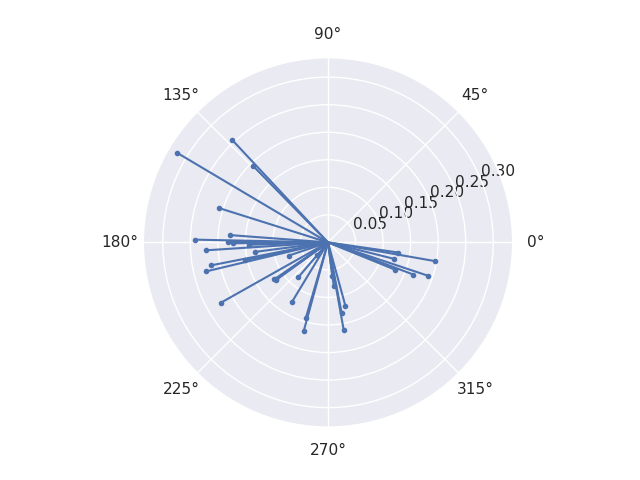

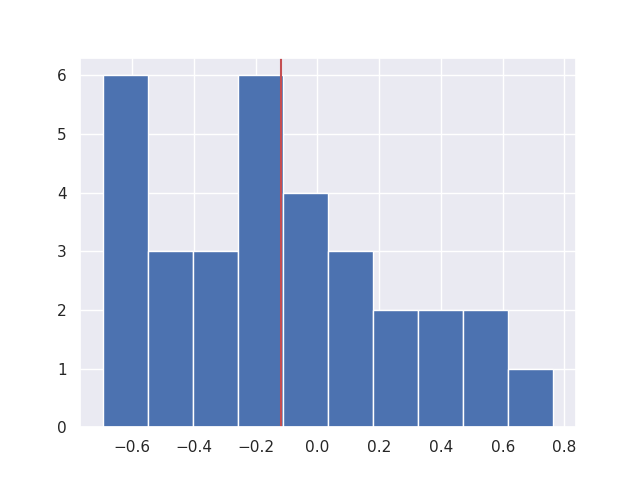

In [141]:
entropy_changes = list()
for event_features in spec_spat_features[6]:
    entropies = list()
    for t_samp_phases in event_features['phases']:
    
        magnitudes = np.abs(t_samp_phases)
        angles = np.angle(t_samp_phases)
        
        n_bins = 24
        pmf, bins = np.histogram(angles, bins=n_bins, density=True)
        entropy = scipy.stats.entropy(pmf, np.ones((n_bins,)) / n_bins) # KL-divergence from uniform distribution
        entropies.append(entropy)
    entropy_changes.append(entropies[1] - entropies[0])

fig, ax = plt.subplots(1, 1, subplot_kw={'projection': 'polar'})
ax.stem(angles, magnitudes, markerfmt='.')

fig, ax = plt.subplots(1, 1)

ax.hist(entropy_changes)
ax.axvline(np.mean(entropy_changes), c='r')

In [28]:
np.angle(np.sum(x))

-2.7554259041923608

In [14]:
print(spec_spat_features)

(1.6329113924050633, 0.13453046806005298, 22.227272727272727, 1.787220026350461, 0.976459955842707, 0.09846113701698922)


In [9]:
# test analysis pipeline
data_type_dir = op.join(data_dir, data_type)
spec_spat_features = get_features(subj_ids[0], series_nums[0], data_type_dir)

# plot two successive post-event topographies in the pre-TMS session
_, epochs_info, _ = read_data(subj_ids[0], series_nums[0], data_type_dir)
fig, axes = plt.subplots(1, 2)
im_1, _ = plot_topomap(spec_spat_features[4][0][0], epochs_info, axes=axes[0],
                       vmin=-0.2, vmax=0.2, show=False)
plt.colorbar(im_1, ax=axes[0], fraction=0.05)
im_2, _ = plot_topomap(spec_spat_features[4][0][1], epochs_info, axes=axes[1],
                       vmin=-0.2, vmax=0.2, show=True)
plt.colorbar(im_2, ax=axes[1], fraction=0.05)

Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_3/T1/preprocessed/0026_Pre_Session1_Series3_Preprocessed.set...
Not setting metadata
79 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_3/T2/preprocessed/0026_Post_Session1_Series3_Preprocessed.set...
Not setting metadata
86 matching events found


/tmp/ipykernel_134628/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)
/tmp/ipykernel_134628/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


No baseline correction applied
0 projection items activated
Ready.
Found 203 global spectral events!!!
Kept 107 events for analysis!!!
shape: (107, 64, 299)
> /tmp/ipykernel_134628/2418046904.py(28)cross_spectral_decomp()
     26         U, s, Vh = np.linalg.svd(c_mat_agg.mean(axis=0))
     27         pdb.set_trace()
---> 28         comp_1.append(Vh[0])
     29 
     30     return comp_1[0], comp_1[1]

ipdb> Vh
array([[-0.02588516, -0.09475999, -0.15976416, ...,  0.16787171,
        -0.04988146,  0.04911718],
       [ 0.20051307,  0.19050289,  0.12749832, ..., -0.11746141,
        -0.12270424, -0.1242573 ],
       [ 0.22110282,  0.2134898 ,  0.15863421, ..., -0.01589887,
        -0.06105223,  0.07596627],
       ...,
       [ 0.00356599, -0.0206539 ,  0.0121998 , ..., -0.18590969,
         0.18044825, -0.00777287],
       [ 0.02974765, -0.002205  ,  0.00936559, ..., -0.52179642,
        -0.02897513, -0.00964158],
       [ 0.02522348, -0.02482114,  0.00144699, ..., -0.13465778,
        

BdbQuit: 

## Run main pipeline for feature extraction

In [15]:
features = np.zeros((n_subj_series, 6))

data_type_dir = op.join(data_dir, data_type)
for idx in range(n_subj_series):
    features[idx] = get_features(subj_ids[idx], series_nums[idx], data_type_dir)

Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_3/T1/preprocessed/0026_Pre_Session1_Series3_Preprocessed.set...
Not setting metadata
79 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_3/T2/preprocessed/0026_Post_Session1_Series3_Preprocessed.set...
Not setting metadata
86 matching events found


/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)
/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


No baseline correction applied
0 projection items activated
Ready.
Found 129 global spectral events in this session!!!
Kept 66 events for analysis in this session!!!
Found 152 global spectral events in this session!!!
Kept 69 events for analysis in this session!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_4/T1/preprocessed/0091_Pre_Session1_Series4_Preprocessed.set...
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_4/T2/preprocessed/0091_Post_Session1_Series4_Preprocessed.set...
Not setting metadata
56 matching events found
No baseline correction applied
0 projection items activated
Ready.


/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)
/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


Found 142 global spectral events in this session!!!
Kept 64 events for analysis in this session!!!
Found 87 global spectral events in this session!!!
Kept 47 events for analysis in this session!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_3/T1/preprocessed/0116_Pre_Session1_Series3_Preprocessed.set...
Not setting metadata
75 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_3/T2/preprocessed/0116_Post_Session1_Series3_Preprocessed.set...
Not setting metadata
72 matching events found


/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)
/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


No baseline correction applied
0 projection items activated
Ready.
Found 110 global spectral events in this session!!!
Kept 53 events for analysis in this session!!!
Found 129 global spectral events in this session!!!
Kept 67 events for analysis in this session!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_2/T1/preprocessed/0167_Pre_Session1_Series2_Preprocessed.set...
Not setting metadata
96 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_2/T2/preprocessed/0167_Post_Session1_Series2_Preprocessed.set...


/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)
/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


Not setting metadata
100 matching events found
No baseline correction applied
0 projection items activated
Ready.
Found 120 global spectral events in this session!!!
Kept 65 events for analysis in this session!!!
Found 117 global spectral events in this session!!!
Kept 69 events for analysis in this session!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_3/T1/preprocessed/0192_Pre_Session1_Series3_Preprocessed.set...
Not setting metadata
25 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_3/T2/preprocessed/0192_Post_Session1_Series3_Preprocessed.set...
Not setting metadata
79 matching events found
No baseline correction applied
0 projection items activated
Ready.


/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)
/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


Found 42 global spectral events in this session!!!
Kept 21 events for analysis in this session!!!
Found 100 global spectral events in this session!!!
Kept 49 events for analysis in this session!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_4/T1/preprocessed/0192_Pre_Session1_Series4_Preprocessed.set...
Not setting metadata
103 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_4/T2/preprocessed/0192_Post_Session1_Series4_Preprocessed.set...


/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)
/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


Not setting metadata
118 matching events found
No baseline correction applied
0 projection items activated
Ready.
Found 169 global spectral events in this session!!!
Kept 80 events for analysis in this session!!!
Found 197 global spectral events in this session!!!
Kept 98 events for analysis in this session!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0246_Pre_Session1_Series1_Preprocessed.set...
Not setting metadata
68 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0246_Post_Session1_Series1_Preprocessed.set...
Not setting metadata
86 matching events found


/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)
/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


No baseline correction applied
0 projection items activated
Ready.
Found 103 global spectral events in this session!!!
Kept 58 events for analysis in this session!!!
Found 173 global spectral events in this session!!!
Kept 89 events for analysis in this session!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0249_Pre_Session1_Series1_Preprocessed.set...
Not setting metadata
72 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0249_Post_Session1_Series1_Preprocessed.set...
Not setting metadata
43 matching events found


/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)
/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


No baseline correction applied
0 projection items activated
Ready.
Found 89 global spectral events in this session!!!
Kept 46 events for analysis in this session!!!
Found 53 global spectral events in this session!!!
Kept 27 events for analysis in this session!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0250_Pre_Session1_Series1_Preprocessed.set...
Not setting metadata
89 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0250_Post_Session1_Series1_Preprocessed.set...
Not setting metadata
73 matching events found


/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)
/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


No baseline correction applied
0 projection items activated
Ready.
Found 154 global spectral events in this session!!!
Kept 81 events for analysis in this session!!!
Found 118 global spectral events in this session!!!
Kept 63 events for analysis in this session!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0255_Pre_Session1_Series1_Preprocessed.set...
Not setting metadata
81 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0255_Post_Session1_Series1_Preprocessed.set...


/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)
/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


Not setting metadata
67 matching events found
No baseline correction applied
0 projection items activated
Ready.
Found 105 global spectral events in this session!!!
Kept 49 events for analysis in this session!!!
Found 93 global spectral events in this session!!!
Kept 44 events for analysis in this session!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0256_Pre_Session1_Series1_Preprocessed.set...
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0256_Post_Session1_Series1_Preprocessed.set...
Not setting metadata
71 matching events found


/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)
/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


No baseline correction applied
0 projection items activated
Ready.
Found 129 global spectral events in this session!!!
Kept 64 events for analysis in this session!!!
Found 128 global spectral events in this session!!!
Kept 65 events for analysis in this session!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_2/T1/preprocessed/0261_Pre_Session1_Series2_Preprocessed.set...
Not setting metadata
101 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_2/T2/preprocessed/0261_Post_Session1_Series2_Preprocessed.set...


/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)
/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


Not setting metadata
87 matching events found
No baseline correction applied
0 projection items activated
Ready.
Found 130 global spectral events in this session!!!
Kept 70 events for analysis in this session!!!
Found 102 global spectral events in this session!!!
Kept 56 events for analysis in this session!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0265_Pre_Session1_Series1_Preprocessed.set...
Not setting metadata
76 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0265_Post_Session1_Series1_Preprocessed.set...
Not setting metadata
72 matching events found


/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)
/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


No baseline correction applied
0 projection items activated
Ready.
Found 101 global spectral events in this session!!!
Kept 46 events for analysis in this session!!!
Found 96 global spectral events in this session!!!
Kept 48 events for analysis in this session!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0266_Pre_Session1_Series1_Preprocessed.set...
Not setting metadata
76 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0266_Post_Session1_Series1_Preprocessed.set...
Not setting metadata
65 matching events found
No baseline correction applied
0 projection items activated
Ready.


/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)
/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


Found 138 global spectral events in this session!!!
Kept 63 events for analysis in this session!!!
Found 131 global spectral events in this session!!!
Kept 66 events for analysis in this session!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0267_Pre_Session1_Series1_Preprocessed.set...
Not setting metadata
74 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0267_Post_Session1_Series1_Preprocessed.set...
Not setting metadata
62 matching events found
No baseline correction applied
0 projection items activated


/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)
/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


Ready.
Found 129 global spectral events in this session!!!
Kept 63 events for analysis in this session!!!
Found 114 global spectral events in this session!!!
Kept 60 events for analysis in this session!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0268_Pre_Session1_Series1_Preprocessed.set...
Not setting metadata
72 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0268_Post_Session1_Series1_Preprocessed.set...
Not setting metadata
68 matching events found
No baseline correction applied
0 projection items activated
Ready.


/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)
/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


Found 79 global spectral events in this session!!!
Kept 44 events for analysis in this session!!!
Found 89 global spectral events in this session!!!
Kept 48 events for analysis in this session!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0274_Pre_Session1_Series1_Preprocessed.set...
Not setting metadata
99 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0274_Post_Session1_Series1_Preprocessed.set...


/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)
/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


Not setting metadata
103 matching events found
No baseline correction applied
0 projection items activated
Ready.
Found 134 global spectral events in this session!!!
Kept 61 events for analysis in this session!!!
Found 110 global spectral events in this session!!!
Kept 62 events for analysis in this session!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0291_Pre_Session1_Series1_Preprocessed.set...
Not setting metadata
95 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0291_Post_Session1_Series1_Preprocessed.set...
Not setting metadata
58 matching events found
No baseline correction applied
0 projection items activated
Ready.


/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)
/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


Found 132 global spectral events in this session!!!
Kept 70 events for analysis in this session!!!
Found 84 global spectral events in this session!!!
Kept 46 events for analysis in this session!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0293_Pre_Session1_Series1_Preprocessed.set...
Not setting metadata
101 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0293_Post_Session1_Series1_Preprocessed.set...


/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)
/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


Not setting metadata
42 matching events found
No baseline correction applied
0 projection items activated
Ready.
Found 155 global spectral events in this session!!!
Kept 82 events for analysis in this session!!!
Found 70 global spectral events in this session!!!
Kept 39 events for analysis in this session!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_2/T1/preprocessed/0293_Pre_Session1_Series2_Preprocessed.set...
Not setting metadata
106 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_2/T2/preprocessed/0293_Post_Session1_Series2_Preprocessed.set...


/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)
/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


Not setting metadata
93 matching events found
No baseline correction applied
0 projection items activated
Ready.
Found 170 global spectral events in this session!!!
Kept 86 events for analysis in this session!!!
Found 140 global spectral events in this session!!!
Kept 60 events for analysis in this session!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0295_Pre_Session1_Series1_Preprocessed.set...
Not setting metadata
79 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0295_Post_Session1_Series1_Preprocessed.set...
Not setting metadata
74 matching events found


/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)
/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


No baseline correction applied
0 projection items activated
Ready.
Found 102 global spectral events in this session!!!
Kept 58 events for analysis in this session!!!
Found 82 global spectral events in this session!!!
Kept 39 events for analysis in this session!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_2/T1/preprocessed/0295_Pre_Session1_Series2_Preprocessed.set...
Not setting metadata
117 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_2/T2/preprocessed/0295_Post_Session1_Series2_Preprocessed.set...


/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)
/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


Not setting metadata
105 matching events found
No baseline correction applied
0 projection items activated
Ready.
Found 141 global spectral events in this session!!!
Kept 73 events for analysis in this session!!!
Found 122 global spectral events in this session!!!
Kept 57 events for analysis in this session!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_2/T1/preprocessed/0296_Pre_Session1_Series2_Preprocessed.set...
Not setting metadata
86 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_2/T2/preprocessed/0296_Post_Session1_Series2_Preprocessed.set...


/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)
/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


Not setting metadata
81 matching events found
No baseline correction applied
0 projection items activated
Ready.
Found 141 global spectral events in this session!!!
Kept 58 events for analysis in this session!!!
Found 126 global spectral events in this session!!!
Kept 62 events for analysis in this session!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_3/T1/preprocessed/0296_Pre_Session1_Series3_Preprocessed.set...
Not setting metadata
93 matching events found
No baseline correction applied
0 projection items activated
Ready.


/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_3/T2/preprocessed/0296_Post_Session1_Series3_Preprocessed.set...
Not setting metadata
121 matching events found
No baseline correction applied
0 projection items activated
Ready.


/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


Found 129 global spectral events in this session!!!
Kept 60 events for analysis in this session!!!
Found 175 global spectral events in this session!!!
Kept 75 events for analysis in this session!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0302_Pre_Session1_Series1_Preprocessed.set...
Not setting metadata
74 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0302_Post_Session1_Series1_Preprocessed.set...
Not setting metadata
78 matching events found


/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)
/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


No baseline correction applied
0 projection items activated
Ready.
Found 136 global spectral events in this session!!!
Kept 61 events for analysis in this session!!!
Found 132 global spectral events in this session!!!
Kept 65 events for analysis in this session!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0305_Pre_Session1_Series1_Preprocessed.set...
Not setting metadata
93 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0305_Post_Session1_Series1_Preprocessed.set...
Not setting metadata
76 matching events found


/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)
/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


No baseline correction applied
0 projection items activated
Ready.
Found 154 global spectral events in this session!!!
Kept 74 events for analysis in this session!!!
Found 106 global spectral events in this session!!!
Kept 47 events for analysis in this session!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0310_Pre_Session1_Series1_Preprocessed.set...
Not setting metadata
97 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0310_Post_Session1_Series1_Preprocessed.set...


/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)
/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


Not setting metadata
96 matching events found
No baseline correction applied
0 projection items activated
Ready.
Found 120 global spectral events in this session!!!
Kept 58 events for analysis in this session!!!
Found 118 global spectral events in this session!!!
Kept 60 events for analysis in this session!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0313_Pre_Session1_Series1_Preprocessed.set...
Not setting metadata
82 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0313_Post_Session1_Series1_Preprocessed.set...
Not setting metadata
81 matching events found


/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)
/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


No baseline correction applied
0 projection items activated
Ready.
Found 145 global spectral events in this session!!!
Kept 65 events for analysis in this session!!!
Found 144 global spectral events in this session!!!
Kept 70 events for analysis in this session!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0317_Pre_Session1_Series1_Preprocessed.set...
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0317_Post_Session1_Series1_Preprocessed.set...
Not setting metadata
75 matching events found


/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)
/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


No baseline correction applied
0 projection items activated
Ready.
Found 134 global spectral events in this session!!!
Kept 75 events for analysis in this session!!!
Found 106 global spectral events in this session!!!
Kept 61 events for analysis in this session!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_2/T1/preprocessed/0320_Pre_Session1_Series2_Preprocessed.set...
Not setting metadata
91 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_2/T2/preprocessed/0320_Post_Session1_Series2_Preprocessed.set...


/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)
/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


Not setting metadata
94 matching events found
No baseline correction applied
0 projection items activated
Ready.
Found 115 global spectral events in this session!!!
Kept 51 events for analysis in this session!!!
Found 77 global spectral events in this session!!!
Kept 33 events for analysis in this session!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_2/T1/preprocessed/0326_Pre_Session1_Series2_Preprocessed.set...
Not setting metadata
120 matching events found
No baseline correction applied
0 projection items activated
Ready.


/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_2/T2/preprocessed/0326_Post_Session1_Series2_Preprocessed.set...
Not setting metadata
105 matching events found
No baseline correction applied
0 projection items activated
Ready.


/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


Found 147 global spectral events in this session!!!
Kept 70 events for analysis in this session!!!
Found 153 global spectral events in this session!!!
Kept 67 events for analysis in this session!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0330_Pre_Session1_Series1_Preprocessed.set...
Not setting metadata
99 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0330_Post_Session1_Series1_Preprocessed.set...
Not setting metadata
74 matching events found


/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)
/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


No baseline correction applied
0 projection items activated
Ready.
Found 143 global spectral events in this session!!!
Kept 71 events for analysis in this session!!!
Found 131 global spectral events in this session!!!
Kept 57 events for analysis in this session!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0332_Pre_Session1_Series1_Preprocessed.set...
Not setting metadata
93 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0332_Post_Session1_Series1_Preprocessed.set...


/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)
/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


Not setting metadata
91 matching events found
No baseline correction applied
0 projection items activated
Ready.
Found 166 global spectral events in this session!!!
Kept 75 events for analysis in this session!!!
Found 177 global spectral events in this session!!!
Kept 87 events for analysis in this session!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0335_Pre_Session1_Series1_Preprocessed.set...
Not setting metadata
88 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0335_Post_Session1_Series1_Preprocessed.set...
Not setting metadata
78 matching events found


/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)
/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


No baseline correction applied
0 projection items activated
Ready.
Found 168 global spectral events in this session!!!
Kept 85 events for analysis in this session!!!
Found 145 global spectral events in this session!!!
Kept 73 events for analysis in this session!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0336_Pre_Session1_Series1_Preprocessed.set...
Not setting metadata
79 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0336_Post_Session1_Series1_Preprocessed.set...
Not setting metadata
42 matching events found
No baseline correction applied
0 projection items activated
Ready.


/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)
/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


Found 87 global spectral events in this session!!!
Kept 49 events for analysis in this session!!!
Found 50 global spectral events in this session!!!
Kept 26 events for analysis in this session!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0340_Pre_Session1_Series1_Preprocessed.set...
Not setting metadata
86 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0340_Post_Session1_Series1_Preprocessed.set...
Not setting metadata
84 matching events found


/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)
/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


No baseline correction applied
0 projection items activated
Ready.
Found 113 global spectral events in this session!!!
Kept 65 events for analysis in this session!!!
Found 119 global spectral events in this session!!!
Kept 60 events for analysis in this session!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0341_Pre_Session1_Series1_Preprocessed.set...
Not setting metadata
77 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0341_Post_Session1_Series1_Preprocessed.set...
Not setting metadata
87 matching events found


/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)
/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


No baseline correction applied
0 projection items activated
Ready.
Found 98 global spectral events in this session!!!
Kept 56 events for analysis in this session!!!
Found 130 global spectral events in this session!!!
Kept 60 events for analysis in this session!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0346_Pre_Session1_Series1_Preprocessed.set...
Not setting metadata
134 matching events found
No baseline correction applied
0 projection items activated
Ready.


/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0346_Post_Session1_Series1_Preprocessed.set...
Not setting metadata
137 matching events found
No baseline correction applied
0 projection items activated
Ready.


/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


Found 247 global spectral events in this session!!!
Kept 110 events for analysis in this session!!!
Found 245 global spectral events in this session!!!
Kept 126 events for analysis in this session!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0348_Pre_Session1_Series1_Preprocessed.set...
Not setting metadata
114 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0348_Post_Session1_Series1_Preprocessed.set...


/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)
/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


Not setting metadata
94 matching events found
No baseline correction applied
0 projection items activated
Ready.
Found 164 global spectral events in this session!!!
Kept 77 events for analysis in this session!!!
Found 100 global spectral events in this session!!!
Kept 44 events for analysis in this session!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0352_Pre_Session1_Series1_Preprocessed.set...
Not setting metadata
110 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0352_Post_Session1_Series1_Preprocessed.set...


/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)
/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


Not setting metadata
95 matching events found
No baseline correction applied
0 projection items activated
Ready.
Found 151 global spectral events in this session!!!
Kept 77 events for analysis in this session!!!
Found 110 global spectral events in this session!!!
Kept 41 events for analysis in this session!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0353_Pre_Session1_Series1_Preprocessed.set...
Not setting metadata
112 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0353_Post_Session1_Series1_Preprocessed.set...


/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)
/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


Not setting metadata
94 matching events found
No baseline correction applied
0 projection items activated
Ready.
Found 175 global spectral events in this session!!!
Kept 86 events for analysis in this session!!!
Found 131 global spectral events in this session!!!
Kept 62 events for analysis in this session!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0355_Pre_Session1_Series1_Preprocessed.set...
Not setting metadata
107 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0355_Post_Session1_Series1_Preprocessed.set...


/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)
/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


Not setting metadata
85 matching events found
No baseline correction applied
0 projection items activated
Ready.
Found 106 global spectral events in this session!!!
Kept 61 events for analysis in this session!!!
Found 84 global spectral events in this session!!!
Kept 41 events for analysis in this session!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_3/T1/preprocessed/0356_Pre_Session1_Series3_Preprocessed.set...
Not setting metadata
88 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_3/T2/preprocessed/0356_Post_Session1_Series3_Preprocessed.set...
Not setting metadata
96 matching events found


/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)
/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


No baseline correction applied
0 projection items activated
Ready.
Found 106 global spectral events in this session!!!
Kept 61 events for analysis in this session!!!
Found 138 global spectral events in this session!!!
Kept 70 events for analysis in this session!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0357_Pre_Session1_Series1_Preprocessed.set...
Not setting metadata
116 matching events found
No baseline correction applied
0 projection items activated
Ready.


/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0357_Post_Session1_Series1_Preprocessed.set...
Not setting metadata
123 matching events found
No baseline correction applied
0 projection items activated
Ready.


/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


Found 145 global spectral events in this session!!!
Kept 82 events for analysis in this session!!!
Found 182 global spectral events in this session!!!
Kept 97 events for analysis in this session!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0361_Pre_Session1_Series1_Preprocessed.set...
Not setting metadata
102 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0361_Post_Session1_Series1_Preprocessed.set...


/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)
/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


Not setting metadata
79 matching events found
No baseline correction applied
0 projection items activated
Ready.
Found 168 global spectral events in this session!!!
Kept 88 events for analysis in this session!!!
Found 141 global spectral events in this session!!!
Kept 58 events for analysis in this session!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0362_Pre_Session1_Series1_Preprocessed.set...
Not setting metadata
121 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0362_Post_Session1_Series1_Preprocessed.set...


/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)
/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


Not setting metadata
97 matching events found
No baseline correction applied
0 projection items activated
Ready.
Found 188 global spectral events in this session!!!
Kept 98 events for analysis in this session!!!
Found 116 global spectral events in this session!!!
Kept 64 events for analysis in this session!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_2/T1/preprocessed/0364_Pre_Session1_Series2_Preprocessed.set...
Not setting metadata
97 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_2/T2/preprocessed/0364_Post_Session1_Series2_Preprocessed.set...


/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)
/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


Not setting metadata
84 matching events found
No baseline correction applied
0 projection items activated
Ready.
Found 129 global spectral events in this session!!!
Kept 68 events for analysis in this session!!!
Found 95 global spectral events in this session!!!
Kept 53 events for analysis in this session!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0365_Pre_Session1_Series1_Preprocessed.set...
Not setting metadata
113 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0365_Post_Session1_Series1_Preprocessed.set...


/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)
/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


Not setting metadata
100 matching events found
No baseline correction applied
0 projection items activated
Ready.
Found 127 global spectral events in this session!!!
Kept 65 events for analysis in this session!!!
Found 87 global spectral events in this session!!!
Kept 35 events for analysis in this session!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0367_Pre_Session1_Series1_Preprocessed.set...
Not setting metadata
92 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0367_Post_Session1_Series1_Preprocessed.set...


/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)
/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


Not setting metadata
88 matching events found
No baseline correction applied
0 projection items activated
Ready.
Found 151 global spectral events in this session!!!
Kept 62 events for analysis in this session!!!
Found 118 global spectral events in this session!!!
Kept 43 events for analysis in this session!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0370_Pre_Session1_Series1_Preprocessed.set...
Not setting metadata
107 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0370_Post_Session1_Series1_Preprocessed.set...


/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)
/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


Not setting metadata
105 matching events found
No baseline correction applied
0 projection items activated
Ready.
Found 157 global spectral events in this session!!!
Kept 79 events for analysis in this session!!!
Found 147 global spectral events in this session!!!
Kept 70 events for analysis in this session!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_2/T1/preprocessed/0370_Pre_Session1_Series2_Preprocessed.set...
Not setting metadata
92 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_2/T2/preprocessed/0370_Post_Session1_Series2_Preprocessed.set...
Not setting metadata
78 matching events found


/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)
/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


No baseline correction applied
0 projection items activated
Ready.
Found 132 global spectral events in this session!!!
Kept 68 events for analysis in this session!!!
Found 128 global spectral events in this session!!!
Kept 66 events for analysis in this session!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0372_Pre_Session1_Series1_Preprocessed.set...
Not setting metadata
81 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0372_Post_Session1_Series1_Preprocessed.set...
Not setting metadata
81 matching events found


/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)
/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


No baseline correction applied
0 projection items activated
Ready.
Found 160 global spectral events in this session!!!
Kept 81 events for analysis in this session!!!
Found 148 global spectral events in this session!!!
Kept 64 events for analysis in this session!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_2/T1/preprocessed/0373_Pre_Session1_Series2_Preprocessed.set...
Not setting metadata
37 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_2/T2/preprocessed/0373_Post_Session1_Series2_Preprocessed.set...
Not setting metadata
87 matching events found
No baseline correction applied
0 projection items activated
Ready.


/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)
/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


Found 45 global spectral events in this session!!!
Kept 22 events for analysis in this session!!!
Found 163 global spectral events in this session!!!
Kept 73 events for analysis in this session!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0376_Pre_Session1_Series1_Preprocessed.set...
Not setting metadata
97 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0376_Post_Session1_Series1_Preprocessed.set...


/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)
/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


Not setting metadata
99 matching events found
No baseline correction applied
0 projection items activated
Ready.
Found 163 global spectral events in this session!!!
Kept 68 events for analysis in this session!!!
Found 165 global spectral events in this session!!!
Kept 70 events for analysis in this session!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0377_Pre_Session1_Series1_Preprocessed.set...
Not setting metadata
85 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0377_Post_Session1_Series1_Preprocessed.set...
Not setting metadata


/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)
/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


83 matching events found
No baseline correction applied
0 projection items activated
Ready.
Found 94 global spectral events in this session!!!
Kept 45 events for analysis in this session!!!
Found 101 global spectral events in this session!!!
Kept 48 events for analysis in this session!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0378_Pre_Session1_Series1_Preprocessed.set...
Not setting metadata
85 matching events found
No baseline correction applied
0 projection items activated
Ready.


/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0378_Post_Session1_Series1_Preprocessed.set...
Not setting metadata
82 matching events found
No baseline correction applied
0 projection items activated
Ready.


/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


Found 79 global spectral events in this session!!!
Kept 43 events for analysis in this session!!!
Found 95 global spectral events in this session!!!
Kept 51 events for analysis in this session!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_3/T1/preprocessed/0378_Pre_Session1_Series3_Preprocessed.set...
Not setting metadata
111 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_3/T2/preprocessed/0378_Post_Session1_Series3_Preprocessed.set...


/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)
/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


Not setting metadata
98 matching events found
No baseline correction applied
0 projection items activated
Ready.
Found 107 global spectral events in this session!!!
Kept 57 events for analysis in this session!!!
Found 93 global spectral events in this session!!!
Kept 59 events for analysis in this session!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0379_Pre_Session1_Series1_Preprocessed.set...
Not setting metadata
86 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0379_Post_Session1_Series1_Preprocessed.set...
Not setting metadata


/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)
/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


86 matching events found
No baseline correction applied
0 projection items activated
Ready.
Found 126 global spectral events in this session!!!
Kept 61 events for analysis in this session!!!
Found 141 global spectral events in this session!!!
Kept 69 events for analysis in this session!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0380_Pre_Session1_Series1_Preprocessed.set...
Not setting metadata
81 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0380_Post_Session1_Series1_Preprocessed.set...


/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)
/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


Not setting metadata
72 matching events found
No baseline correction applied
0 projection items activated
Ready.
Found 96 global spectral events in this session!!!
Kept 49 events for analysis in this session!!!
Found 96 global spectral events in this session!!!
Kept 49 events for analysis in this session!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0386_Pre_Session1_Series1_Preprocessed.set...
Not setting metadata
84 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0386_Post_Session1_Series1_Preprocessed.set...
Not setting metadata
69 matching events found


/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)
/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


No baseline correction applied
0 projection items activated
Ready.
Found 107 global spectral events in this session!!!
Kept 52 events for analysis in this session!!!
Found 111 global spectral events in this session!!!
Kept 44 events for analysis in this session!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0389_Pre_Session1_Series1_Preprocessed.set...
Not setting metadata
87 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0389_Post_Session1_Series1_Preprocessed.set...


/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)
/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


Not setting metadata
90 matching events found
No baseline correction applied
0 projection items activated
Ready.
Found 97 global spectral events in this session!!!
Kept 53 events for analysis in this session!!!
Found 113 global spectral events in this session!!!
Kept 57 events for analysis in this session!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0390_Pre_Session1_Series1_Preprocessed.set...
Not setting metadata
85 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0390_Post_Session1_Series1_Preprocessed.set...


/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)
/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


Not setting metadata
111 matching events found
No baseline correction applied
0 projection items activated
Ready.
Found 82 global spectral events in this session!!!
Kept 36 events for analysis in this session!!!
Found 111 global spectral events in this session!!!
Kept 49 events for analysis in this session!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0392_Pre_Session1_Series1_Preprocessed.set...
Not setting metadata
85 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0392_Post_Session1_Series1_Preprocessed.set...
Not setting metadata
86 matching events found


/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)
/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


No baseline correction applied
0 projection items activated
Ready.
Found 126 global spectral events in this session!!!
Kept 62 events for analysis in this session!!!
Found 118 global spectral events in this session!!!
Kept 63 events for analysis in this session!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0401_Pre_Session1_Series1_Preprocessed.set...
Not setting metadata
82 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0401_Post_Session1_Series1_Preprocessed.set...
Not setting metadata


/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)
/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


90 matching events found
No baseline correction applied
0 projection items activated
Ready.
Found 120 global spectral events in this session!!!
Kept 59 events for analysis in this session!!!
Found 81 global spectral events in this session!!!
Kept 46 events for analysis in this session!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0406_Pre_Session1_Series1_Preprocessed.set...
Not setting metadata
85 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0406_Post_Session1_Series1_Preprocessed.set...
Not setting metadata
74 matching events found


/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)
/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


No baseline correction applied
0 projection items activated
Ready.
Found 114 global spectral events in this session!!!
Kept 53 events for analysis in this session!!!
Found 106 global spectral events in this session!!!
Kept 47 events for analysis in this session!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0407_Pre_Session1_Series1_Preprocessed.set...
Not setting metadata
119 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0407_Post_Session1_Series1_Preprocessed.set...


/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)
/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


Not setting metadata
76 matching events found
No baseline correction applied
0 projection items activated
Ready.
Found 72 global spectral events in this session!!!
Kept 36 events for analysis in this session!!!
Found 99 global spectral events in this session!!!
Kept 44 events for analysis in this session!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0409_Pre_Session1_Series1_Preprocessed.set...
Not setting metadata
88 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0409_Post_Session1_Series1_Preprocessed.set...
Not setting metadata
26 matching events found
No baseline correction applied
0 projection items activated
Ready.


/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)
/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


Found 86 global spectral events in this session!!!
Kept 40 events for analysis in this session!!!
Found 23 global spectral events in this session!!!
Kept 12 events for analysis in this session!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0413_Pre_Session1_Series1_Preprocessed.set...
Not setting metadata
82 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0413_Post_Session1_Series1_Preprocessed.set...


/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)
/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


Not setting metadata
97 matching events found
No baseline correction applied
0 projection items activated
Ready.
Found 127 global spectral events in this session!!!
Kept 67 events for analysis in this session!!!
Found 152 global spectral events in this session!!!
Kept 72 events for analysis in this session!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0415_Pre_Session1_Series1_Preprocessed.set...
Not setting metadata
89 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0415_Post_Session1_Series1_Preprocessed.set...
Not setting metadata
78 matching events found


/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)
/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


No baseline correction applied
0 projection items activated
Ready.
Found 103 global spectral events in this session!!!
Kept 50 events for analysis in this session!!!
Found 85 global spectral events in this session!!!
Kept 35 events for analysis in this session!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0416_Pre_Session1_Series1_Preprocessed.set...
Not setting metadata
83 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0416_Post_Session1_Series1_Preprocessed.set...
Not setting metadata
67 matching events found
No baseline correction applied
0 projection items activated
Ready.


/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)
/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


Found 119 global spectral events in this session!!!
Kept 56 events for analysis in this session!!!
Found 55 global spectral events in this session!!!
Kept 29 events for analysis in this session!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0418_Pre_Session1_Series1_Preprocessed.set...
Not setting metadata
115 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0418_Post_Session1_Series1_Preprocessed.set...


/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)
/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


Not setting metadata
71 matching events found
No baseline correction applied
0 projection items activated
Ready.
Found 191 global spectral events in this session!!!
Kept 91 events for analysis in this session!!!
Found 115 global spectral events in this session!!!
Kept 58 events for analysis in this session!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0419_Pre_Session1_Series1_Preprocessed.set...
Not setting metadata
101 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0419_Post_Session1_Series1_Preprocessed.set...
Not setting metadata
76 matching events found


/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)
/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


No baseline correction applied
0 projection items activated
Ready.
Found 126 global spectral events in this session!!!
Kept 65 events for analysis in this session!!!
Found 111 global spectral events in this session!!!
Kept 59 events for analysis in this session!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_2/T1/preprocessed/0419_Pre_Session1_Series2_Preprocessed.set...
Not setting metadata
115 matching events found
No baseline correction applied
0 projection items activated
Ready.


/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_2/T2/preprocessed/0419_Post_Session1_Series2_Preprocessed.set...
Not setting metadata
81 matching events found
No baseline correction applied
0 projection items activated
Ready.


/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


Found 147 global spectral events in this session!!!
Kept 68 events for analysis in this session!!!
Found 79 global spectral events in this session!!!
Kept 37 events for analysis in this session!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0420_Pre_Session1_Series1_Preprocessed.set...
Not setting metadata
78 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0420_Post_Session1_Series1_Preprocessed.set...
Not setting metadata
76 matching events found


/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)
/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


No baseline correction applied
0 projection items activated
Ready.
Found 115 global spectral events in this session!!!
Kept 56 events for analysis in this session!!!
Found 91 global spectral events in this session!!!
Kept 49 events for analysis in this session!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_2/T1/preprocessed/0421_Pre_Session1_Series2_Preprocessed.set...
Not setting metadata
78 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_2/T2/preprocessed/0421_Post_Session1_Series2_Preprocessed.set...


/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)
/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


Not setting metadata
106 matching events found
No baseline correction applied
0 projection items activated
Ready.
Found 151 global spectral events in this session!!!
Kept 75 events for analysis in this session!!!
Found 200 global spectral events in this session!!!
Kept 93 events for analysis in this session!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_3/T1/preprocessed/0421_Pre_Session1_Series3_Preprocessed.set...
Not setting metadata
72 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_3/T2/preprocessed/0421_Post_Session1_Series3_Preprocessed.set...
Not setting metadata
68 matching events found
No baseline correction applied
0 projection items activated
Ready.


/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)
/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


Found 159 global spectral events in this session!!!
Kept 75 events for analysis in this session!!!
Found 126 global spectral events in this session!!!
Kept 69 events for analysis in this session!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0422_Pre_Session1_Series1_Preprocessed.set...
Not setting metadata
86 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0422_Post_Session1_Series1_Preprocessed.set...
Not setting metadata
45 matching events found
No baseline correction applied
0 projection items activated
Ready.


/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)
/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


Found 120 global spectral events in this session!!!
Kept 62 events for analysis in this session!!!
Found 58 global spectral events in this session!!!
Kept 27 events for analysis in this session!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0423_Pre_Session1_Series1_Preprocessed.set...
Not setting metadata
84 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0423_Post_Session1_Series1_Preprocessed.set...
Not setting metadata
71 matching events found


/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)
/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


No baseline correction applied
0 projection items activated
Ready.
Found 118 global spectral events in this session!!!
Kept 55 events for analysis in this session!!!
Found 91 global spectral events in this session!!!
Kept 43 events for analysis in this session!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0431_Pre_Session1_Series1_Preprocessed.set...
Not setting metadata
81 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0431_Post_Session1_Series1_Preprocessed.set...
Not setting metadata
82 matching events found


/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)
/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


No baseline correction applied
0 projection items activated
Ready.
Found 100 global spectral events in this session!!!
Kept 57 events for analysis in this session!!!
Found 85 global spectral events in this session!!!
Kept 38 events for analysis in this session!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0436_Pre_Session1_Series1_Preprocessed.set...
Not setting metadata
81 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0436_Post_Session1_Series1_Preprocessed.set...
Not setting metadata
80 matching events found


/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)
/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


No baseline correction applied
0 projection items activated
Ready.
Found 81 global spectral events in this session!!!
Kept 48 events for analysis in this session!!!
Found 95 global spectral events in this session!!!
Kept 50 events for analysis in this session!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_2/T1/preprocessed/0436_Pre_Session1_Series2_Preprocessed.set...
Not setting metadata
81 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_2/T2/preprocessed/0436_Post_Session1_Series2_Preprocessed.set...
Not setting metadata
87 matching events found


/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)
/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


No baseline correction applied
0 projection items activated
Ready.
Found 106 global spectral events in this session!!!
Kept 51 events for analysis in this session!!!
Found 137 global spectral events in this session!!!
Kept 65 events for analysis in this session!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0437_Pre_Session1_Series1_Preprocessed.set...
Not setting metadata
83 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0437_Post_Session1_Series1_Preprocessed.set...


/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)
/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


Not setting metadata
71 matching events found
No baseline correction applied
0 projection items activated
Ready.
Found 121 global spectral events in this session!!!
Kept 59 events for analysis in this session!!!
Found 98 global spectral events in this session!!!
Kept 47 events for analysis in this session!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0440_Pre_Session1_Series1_Preprocessed.set...
Not setting metadata
111 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0440_Post_Session1_Series1_Preprocessed.set...


/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)
/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


Not setting metadata
81 matching events found
No baseline correction applied
0 projection items activated
Ready.
Found 111 global spectral events in this session!!!
Kept 57 events for analysis in this session!!!
Found 89 global spectral events in this session!!!
Kept 54 events for analysis in this session!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0451_Pre_Session1_Series1_Preprocessed.set...
Not setting metadata
81 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0451_Post_Session1_Series1_Preprocessed.set...
Not setting metadata
76 matching events found


/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)
/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


No baseline correction applied
0 projection items activated
Ready.
Found 94 global spectral events in this session!!!
Kept 45 events for analysis in this session!!!
Found 74 global spectral events in this session!!!
Kept 42 events for analysis in this session!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0461_Pre_Session1_Series1_Preprocessed.set...
Not setting metadata
92 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0461_Post_Session1_Series1_Preprocessed.set...
Not setting metadata
83 matching events found


/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)
/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


No baseline correction applied
0 projection items activated
Ready.
Found 106 global spectral events in this session!!!
Kept 65 events for analysis in this session!!!
Found 100 global spectral events in this session!!!
Kept 59 events for analysis in this session!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0466_Pre_Session1_Series1_Preprocessed.set...
Not setting metadata
82 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0466_Post_Session1_Series1_Preprocessed.set...
Not setting metadata
76 matching events found


/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)
/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


No baseline correction applied
0 projection items activated
Ready.
Found 111 global spectral events in this session!!!
Kept 53 events for analysis in this session!!!
Found 101 global spectral events in this session!!!
Kept 40 events for analysis in this session!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0467_Pre_Session1_Series1_Preprocessed.set...
Not setting metadata
81 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0467_Post_Session1_Series1_Preprocessed.set...
Not setting metadata
82 matching events found


/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)
/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


No baseline correction applied
0 projection items activated
Ready.
Found 94 global spectral events in this session!!!
Kept 54 events for analysis in this session!!!
Found 74 global spectral events in this session!!!
Kept 25 events for analysis in this session!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0468_Pre_Session1_Series1_Preprocessed.set...
Not setting metadata
94 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0468_Post_Session1_Series1_Preprocessed.set...
Not setting metadata
83 matching events found


/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)
/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


No baseline correction applied
0 projection items activated
Ready.
Found 150 global spectral events in this session!!!
Kept 72 events for analysis in this session!!!
Found 124 global spectral events in this session!!!
Kept 63 events for analysis in this session!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0469_Pre_Session1_Series1_Preprocessed.set...
Not setting metadata
76 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0469_Post_Session1_Series1_Preprocessed.set...
Not setting metadata
66 matching events found
No baseline correction applied
0 projection items activated
Ready.


/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)
/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


Found 102 global spectral events in this session!!!
Kept 48 events for analysis in this session!!!
Found 70 global spectral events in this session!!!
Kept 39 events for analysis in this session!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0472_Pre_Session1_Series1_Preprocessed.set...
Not setting metadata
115 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0472_Post_Session1_Series1_Preprocessed.set...


/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)
/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


Not setting metadata
87 matching events found
No baseline correction applied
0 projection items activated
Ready.
Found 180 global spectral events in this session!!!
Kept 97 events for analysis in this session!!!
Found 129 global spectral events in this session!!!
Kept 56 events for analysis in this session!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_2/T1/preprocessed/0498_Pre_Session1_Series2_Preprocessed.set...
Not setting metadata
98 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_2/T2/preprocessed/0498_Post_Session1_Series2_Preprocessed.set...
Not setting metadata


/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)
/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


82 matching events found
No baseline correction applied
0 projection items activated
Ready.
Found 106 global spectral events in this session!!!
Kept 45 events for analysis in this session!!!
Found 85 global spectral events in this session!!!
Kept 47 events for analysis in this session!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0511_Pre_Session1_Series1_Preprocessed.set...
Not setting metadata
91 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0511_Post_Session1_Series1_Preprocessed.set...


/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)
/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


Not setting metadata
87 matching events found
No baseline correction applied
0 projection items activated
Ready.
Found 155 global spectral events in this session!!!
Kept 78 events for analysis in this session!!!
Found 109 global spectral events in this session!!!
Kept 54 events for analysis in this session!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/9001_Pre_Session1_Series1_Preprocessed.set...
Not setting metadata
98 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/9001_Post_Session1_Series1_Preprocessed.set...
Not setting metadata
76 matching events found


/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)
/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


No baseline correction applied
0 projection items activated
Ready.
Found 118 global spectral events in this session!!!
Kept 62 events for analysis in this session!!!
Found 98 global spectral events in this session!!!
Kept 54 events for analysis in this session!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_2/T1/preprocessed/9001_Pre_Session1_Series2_Preprocessed.set...
Not setting metadata
97 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_2/T2/preprocessed/9001_Post_Session1_Series2_Preprocessed.set...
Not setting metadata
66 matching events found


/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)
/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


No baseline correction applied
0 projection items activated
Ready.
Found 111 global spectral events in this session!!!
Kept 57 events for analysis in this session!!!
Found 83 global spectral events in this session!!!
Kept 44 events for analysis in this session!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_6/T1/preprocessed/9001_Pre_Session1_Series6_Preprocessed.set...
Not setting metadata
83 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_6/T2/preprocessed/9001_Post_Session1_Series6_Preprocessed.set...
Not setting metadata
77 matching events found


/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)
/tmp/ipykernel_53240/2441085883.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


No baseline correction applied
0 projection items activated
Ready.
Found 83 global spectral events in this session!!!
Kept 40 events for analysis in this session!!!
Found 103 global spectral events in this session!!!
Kept 53 events for analysis in this session!!!


## Try to visualize clusters and observe trends

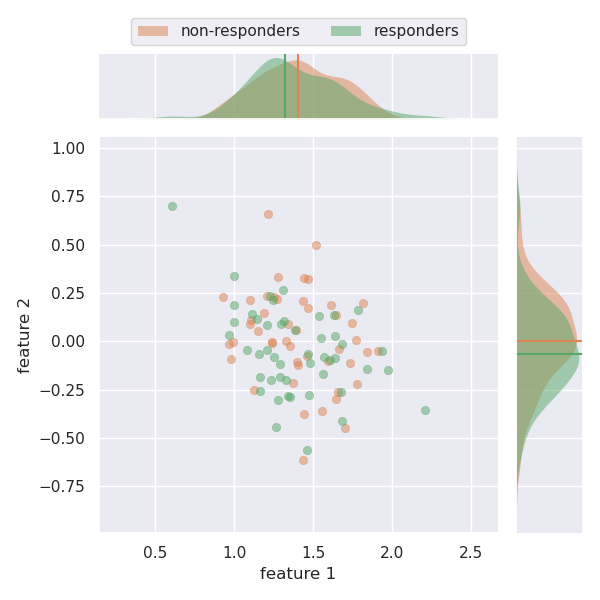

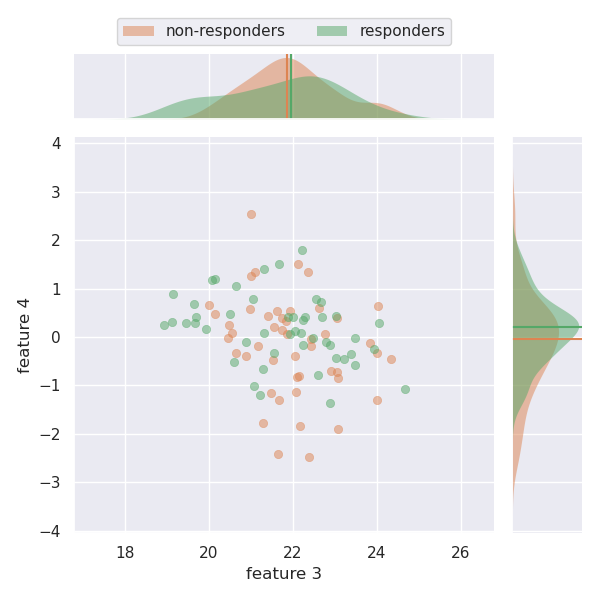

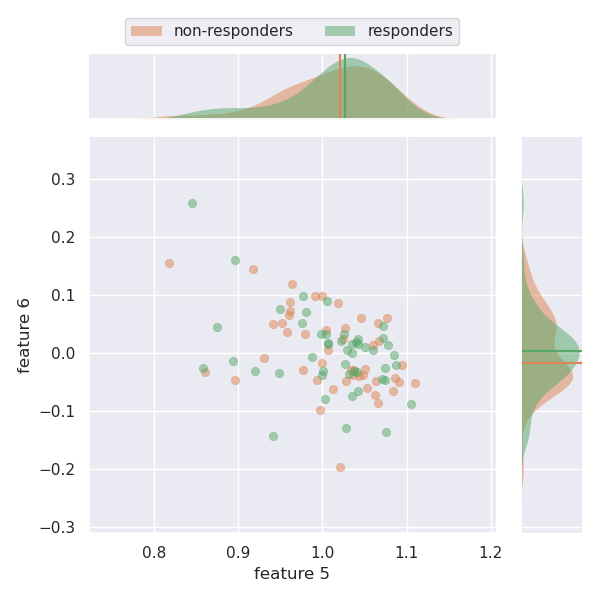

In [17]:
# plot 1st and 2nd features
#ax_labels = [r'$std(W_{sess_2})-std(W_{sess_1})$', r'$\parallel W_{sess_2}-W_{sess_1}\parallel$']
ax_labels = ['feature 1', 'feature 2']
plot_features_scatter(x=features[:, 0], y=features[:, 1], responder_labels=responders, ax_labels=ax_labels)

# plot 3st and 4rd features
#ax_labels = [r'$\Delta$ cross-hemisphere beta event coherence', r'$\parallel W_{sess_2}-W_{sess_1}\parallel$']
ax_labels = ['feature 3', 'feature 4']
plot_features_scatter(x=features[:, 2], y=features[:, 3], responder_labels=responders, ax_labels=ax_labels)

# plot 1st and 3rd features
#ax_labels = [r'$\Delta$ cross-hemisphere beta event coherence', r'$\parallel W_{sess_2}-W_{sess_1}\parallel$']
ax_labels = ['feature 5', 'feature 6']
plot_features_scatter(x=features[:, 4], y=features[:, 5], responder_labels=responders, ax_labels=ax_labels)


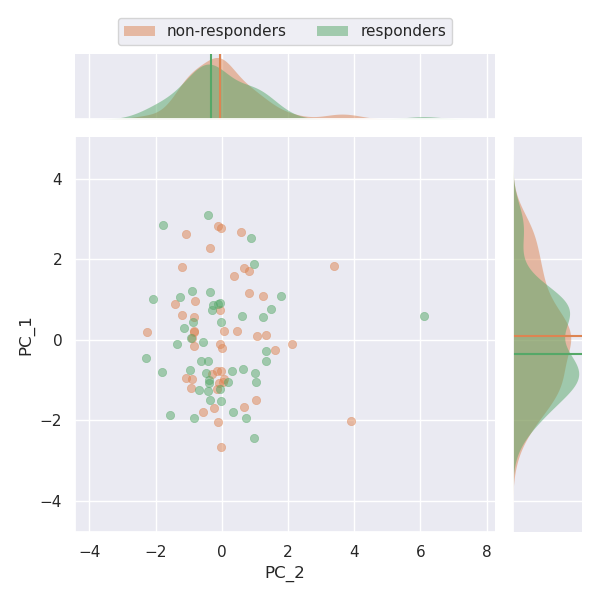

In [29]:
# PCA: see if the two data classes appear to be linearly separable
# answer: nope
X = features.copy()
X = StandardScaler().fit_transform(X)
pca = PCA()
pca.fit(X)
pcs = pca.components_[:2, :]
X_pc = X @ pcs.T

ax_labels = ['PC_2', 'PC_1']
plot_features_scatter(x=X_pc[:, 1], y=X_pc[:, 0], responder_labels=responders, ax_labels=ax_labels)

## Train and validate SVM classifier
- first try omicient version (i.e., training data = testing data)
- then try with separate training and testing datasets, for demographic regressors only
- finally add EEG features

In [11]:
X = np.c_[feat_1, feat_2, feat_3, feat_4, feat_5, ages, sexes, depression_histories, symptoms_init]
X = StandardScaler().fit_transform(X)
svm_cls = svm.SVC(kernel='rbf')
svm_cls.fit(X, responders)
svm_cls.score(X, responders)

0.8

Found 27 global spectral events!!!
Kept 22 events for analysis!!!
shape: (22, 64, 299)
Found 138 global spectral events!!!
Kept 80 events for analysis!!!
shape: (80, 64, 299)


/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.


Found 60 global spectral events!!!
Kept 46 events for analysis!!!
shape: (46, 64, 299)
Found 142 global spectral events!!!
Kept 73 events for analysis!!!
shape: (73, 64, 299)


/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.


Found 158 global spectral events!!!
Kept 91 events for analysis!!!
shape: (91, 64, 299)
Found 164 global spectral events!!!
Kept 86 events for analysis!!!
shape: (86, 64, 299)


/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.


In [33]:
n_perm = 1000
training_set_ratio = 0.7

n_set = n_subj_series
n_training_set = int(np.round(training_set_ratio * n_set))
n_test_set = int(n_set - n_training_set)

accuracy_scores = np.zeros((n_perm,))
for perm_idx in range(n_perm):
    
    set_idxs = np.arange(n_set)
    np.random.shuffle(set_idxs)
    train_idxs = set_idxs[:n_training_set]
    test_idxs = set_idxs[n_training_set:]
    
    # fit to training set
    X_train = np.c_[ages[train_idxs],
                    sexes[train_idxs],
                    depression_histories[train_idxs],
                    symptoms_init[train_idxs]]
    std_scaler = StandardScaler().fit(X_train)
    X_train = std_scaler.transform(X_train)
    Y_train = responders[train_idxs]
    svm_cls = svm.SVC(kernel='linear')
    svm_cls.fit(X_train, Y_train)
    
    # validate on test set
    X_test = np.c_[ages[test_idxs],
                   sexes[test_idxs],
                   depression_histories[test_idxs],
                   symptoms_init[test_idxs]]
    X_test = std_scaler.transform(X_test) 
    Y_test = responders[test_idxs]
    accuracy_scores[perm_idx] = svm_cls.score(X_test, Y_test)

print(f'Mean accuracy: {np.mean(accuracy_scores)}')

Mean accuracy: 0.4410689655172414


In [31]:
n_perm = 1000
training_set_ratio = 0.7

n_set = n_subj_series
n_training_set = int(np.round(training_set_ratio * n_set))
n_test_set = int(n_set - n_training_set)

accuracy_scores = np.zeros((n_perm,))
for perm_idx in range(n_perm):
    
    set_idxs = np.arange(n_set)
    np.random.shuffle(set_idxs)
    train_idxs = set_idxs[:n_training_set]
    test_idxs = set_idxs[n_training_set:]
    
    # fit to training set
    X_train = features.copy()[train_idxs, :]
    std_scaler = StandardScaler().fit(X_train)
    X_train = std_scaler.transform(X_train)
    Y_train = responders[train_idxs]
    svm_cls = svm.SVC(kernel='linear')
    svm_cls.fit(X_train, Y_train)
    
    # validate on test set
    X_test = features.copy()[test_idxs, :]
    X_test = std_scaler.transform(X_test) 
    Y_test = responders[test_idxs]
    accuracy_scores[perm_idx] = svm_cls.score(X_test, Y_test)

print(f'Mean accuracy: {np.mean(accuracy_scores)}')

Mean accuracy: 0.5338965517241379
